# 17 Flowers Classification

In this notebook, we classify the 17 flowers dataset. We'll use both the original dataset, and a color-constancy (CC) version that's been processed by CC methods.

# Imports

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import shutil
import pathlib

2023-04-20 14:03:00.256870: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 14:03:00.939601: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Preprocessing

Based on https://www.tensorflow.org/tutorials/load_data/images

## Organizing the dataset

To load the dataset using `tf.keras.utils.image_dataset_from_directory()`, the dataset must be divided into subfolders for each label. In the case of 17 flowers, we'll have 17 folders.

The 17 labels are:

In [2]:
# list of class labels
with open("17flowers_labels.txt", "r") as f:
    labels = [line.strip() for line in f]

print(labels)

['Daffodil', 'Snowdrop', 'LilyValley', 'Bluebell', 'Crocus', 'Iris', 'Tigerlily', 'Tulip', 'Fritillary', 'Sunflower', 'Daisy', 'ColtsFoot', 'Dandelion', 'Cowslip', 'Buttercup', 'Windflower', 'Pansy']


We'll use the train/val/test splits provided in the dataset. As such, we'll load the `datasplits.mat` file and gets the splits (i.e., the image ids for each split) from its contents.

In [3]:
import scipy.io
mat = scipy.io.loadmat('./data/17flowers/datasplits.mat')

# The image ids for each split
train_ids = mat["trn1"][0]
val_ids = mat["val1"][0]
test_ids = mat["tst1"][0]

# The amount of images in each split
train_size = len(train_ids)
val_size = len(val_ids)
test_size = len(test_ids)

print(f"Training  : {train_size} images.")
print(f"Validation: {val_size} images.")
print(f"Testing   : {test_size} images.")

Training  : 680 images.
Validation: 340 images.
Testing   : 340 images.


Create the 17 subfolders for each split:

In [4]:
# set the path to the folder containing the images
path_to_data = "data/17flowers/"

# for the cc dataset
# path_to_images_cc = "data/cc/17flowers/jpg/"
# new_path_to_images_cc = "data/cc/17flowers/labeled/"

# create the subfolders to hold the images
def create_subfolders(path):
    """
    Use this if you want random train/val split.
    """
    for label in labels:
        os.makedirs(path + label, exist_ok=True)
    print(f"All 17 subfolders created at {path}.")

def create_split_subfolders(path):
    """
    Use this with the datasplits.mat file to split the dataset into train/val/test with specific images.
    """
    for split_name in ["train/", "val/", "test/"]:
        for label in labels:
            os.makedirs(path + split_name + label, exist_ok=True)
    print(f"All subfolders created at {path}.")

create_split_subfolders(path_to_data)
# create_subfolders(new_path_to_images_cc)

All subfolders created at data/17flowers/.


Copy images to their subfolders:

In [5]:
# move the images into the subfolders
def move_images_to_subfolders(path_to_images, new_path_to_images):
    image_count = 0
    for filename in os.listdir(path_to_images):
        if filename.endswith(".jpg"):
            # calculate the subfolder to move the image into
            subfolder_number = image_count // 80  # 80 images per label
            subfolder_name = new_path_to_images + labels[subfolder_number]
            # move the image into the subfolder
            shutil.copy(os.path.join(path_to_images, filename), os.path.join(subfolder_name, filename))
            # increment the image count
            image_count += 1
    print(f"{image_count} images copied successfully to {new_path_to_images}.")


# move the images into the subfolders
def move_images_to_split_subfolders(path):
    """
    Copy images from `path/jpg` to `path` subfolders train/val/test and their labels.
    """
    src_path = path + "jpg/"
    for filename in os.listdir(src_path):
        if filename.endswith(".jpg"):
            # Get the id of the image from its filename
            file_id = int(filename[6:-4])

            # Check which split the file belongs to
            if file_id in train_ids:
                split = "train/"
            elif file_id in val_ids:
                split = "val/"
            elif file_id in test_ids:
                split = "test/"
            else:
                print(f"{filename} isn't associated with any splits.")

            # calculate the subfolder to move the image into
            subfolder_id = (file_id-1) // 80  # File ids start from 1, so subtract one. 80 images per label
            subfolder_name = path + split + labels[subfolder_id]

            # move the image into the subfolder
            shutil.copy(os.path.join(src_path, filename), os.path.join(subfolder_name, filename))
    print(f"Images copied successfully to {path} test/train/val subfolders.")


move_images_to_split_subfolders(path_to_data)
# move_images_to_subfolders(path_to_images_cc, new_path_to_images_cc)

Images copied successfully to data/17flowers/ test/train/val subfolders.


In [6]:
# Split directories
train_dir = pathlib.Path(path_to_data + "train")
val_dir = pathlib.Path(path_to_data + "val")
test_dir = pathlib.Path(path_to_data + "test")

# Image counts
train_count = len(list(train_dir.glob('*/*.jpg')))
val_count = len(list(val_dir.glob('*/*.jpg')))
test_count = len(list(test_dir.glob('*/*.jpg')))

# data_dir_cc = pathlib.Path(new_path_to_images_cc)
# image_count_cc = len(list(data_dir_cc.glob('*/*.jpg')))

print(f"Number of images at {path_to_data}: {train_count}/{train_size} (train), {val_count}/{val_size} (val), {test_count}/{test_size} (test)")
# print(f"Number of images at {new_path_to_images_cc}: {image_count_cc}")

# The number of images in each folder should be the same as the amount of ids provided by the datasplits.mat file
assert train_count == train_size, f"Expected {train_size} images, but {train_dir} only has {train_count}"
assert val_count == val_size, f"Expected {train_size} images, but {val_dir} only has {val_count}"
assert test_count == test_size, f"Expected {train_size} images, but {test_dir} only has {test_count}"

Number of images at data/17flowers/: 680/680 (train), 340/340 (val), 340/340 (test)


## Create the training and validation datasets

Parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Create the train, val, and test datasets:

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 680 files belonging to 17 classes.
Found 340 files belonging to 17 classes.
Found 340 files belonging to 17 classes.


2023-04-20 14:03:02.653450: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-20 14:03:02.698762: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-20 14:03:02.698899: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Verify class names are correct:

In [9]:
class_names = train_ds.class_names

assert sorted(class_names) == sorted(labels)

## Visualize the data

Here are the first 9 images from the training dataset.

2023-04-20 14:03:04.374468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [680]
	 [[{{node Placeholder/_4}}]]
2023-04-20 14:03:04.374759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [680]
	 [[{{node Placeholder/_4}}]]


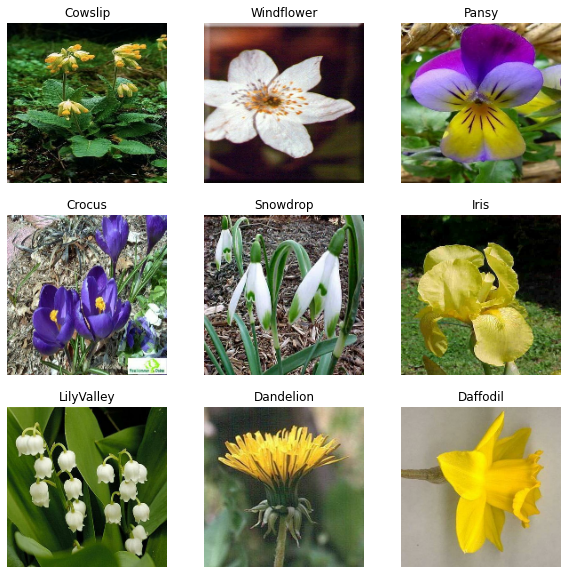

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Retrieve batches of images:

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


2023-04-20 14:03:05.107241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [680]
	 [[{{node Placeholder/_4}}]]
2023-04-20 14:03:05.107708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [680]
	 [[{{node Placeholder/_4}}]]


The image_batch is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, we will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:



In [12]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

We can either apply this layer to the dataset, or include it as part of the model definition. We'll go with the latter.

## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Training and evaluation

We'll create a simple CNN to classify the flowers. Before setting up the architecture, let's define some useful utilities.

## Callbacks

Reduce learning rate on plateau:

In [23]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

Early stopping when loss stops decreasing:

In [24]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

## Data augmentation

Since the dataset is small, we'll use data augmentation to improve training: flip, contrast, brightness, translation, rotation, and zoom.

In [36]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
  tf.keras.layers.RandomContrast(0.2),
  tf.keras.layers.RandomBrightness(0.2),
  tf.keras.layers.RandomTranslation(0.2, 0.2),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
])

Let's check some of the augmented images:

2023-04-20 14:15:52.756325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [680]
	 [[{{node Placeholder/_4}}]]
2023-04-20 14:15:52.757046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [680]
	 [[{{node Placeholder/_4}}]]


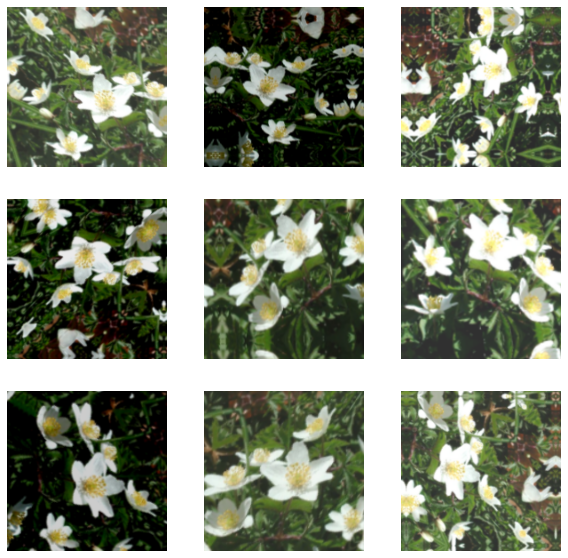

In [37]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Creating the model

Here we create the model for classifying the flowers:

In [94]:
num_classes = 17
n_epochs = 300

def build_model():
  model = tf.keras.Sequential([
    data_augmentation,
    normalization_layer,
    tf.keras.layers.Conv2D(32, 5, activation='relu', padding="same", input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(512, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation="softmax")
  ])
  return model

model = build_model()

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

Now we fit the model:

In [85]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=n_epochs,
  callbacks=[reduce_lr, early_stop]
)

Epoch 1/300
22/22 [==============================] - 3s 36ms/step - loss: 2.8029 - accuracy: 0.0676 - val_loss: 2.5437 - val_accuracy: 0.1235 - lr: 0.0010
Epoch 2/300
22/22 [==============================] - 1s 25ms/step - loss: 2.5519 - accuracy: 0.1118 - val_loss: 2.4126 - val_accuracy: 0.1176 - lr: 0.0010
Epoch 3/300
22/22 [==============================] - 1s 26ms/step - loss: 2.4931 - accuracy: 0.1456 - val_loss: 2.3671 - val_accuracy: 0.1471 - lr: 0.0010
Epoch 4/300
22/22 [==============================] - 1s 27ms/step - loss: 2.3791 - accuracy: 0.1324 - val_loss: 2.1565 - val_accuracy: 0.2529 - lr: 0.0010
Epoch 5/300
22/22 [==============================] - 1s 26ms/step - loss: 2.2722 - accuracy: 0.2103 - val_loss: 2.0326 - val_accuracy: 0.2971 - lr: 0.0010
Epoch 6/300
22/22 [==============================] - 1s 26ms/step - loss: 2.1937 - accuracy: 0.2250 - val_loss: 1.8824 - val_accuracy: 0.3235 - lr: 0.0010
Epoch 7/300
22/22 [==============================] - 1s 27ms/step - lo

And evaluate the model:

In [86]:
score = model.evaluate(test_ds)
print(f'Test accuracy: {score[1]:.3f}')

11/11 [==============================] - 0s 12ms/step - loss: 0.6907 - accuracy: 0.7824
Test accuracy: 0.782


## Tuning the model

We'll use `keras-tuner` to tune the model architecture and its parameters. First, we define a function to build models:

In [87]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import keras_tuner as kt

num_classes = 17

def build_model(hp):
  filters = hp.Int('filters', min_value=32, max_value=512, step=32)
  kernel_size = hp.Choice('kernel_size', [3, 5])
  pool_size = 2

  model = tf.keras.Sequential()
  model.add(normalization_layer)
  model.add(Conv2D(
    filters=filters, 
    kernel_size=(kernel_size, kernel_size), 
    activation='relu', 
    input_shape=(180, 180, 3)))
  model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
  model.add(Flatten())
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # from_logits=True ?
    metrics=['accuracy'])
  
  return model

Initialize the tuner:

In [88]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,
    directory="tuner",
    project_name="td4")

tuner.search_space_summary()

INFO:tensorflow:Reloading Tuner from tuner/td4/tuner0.json
Search space summary
Default search space size: 2
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}


Start the search:

In [89]:
tuner.search(train_ds, epochs=3, validation_data=val_ds)

INFO:tensorflow:Oracle triggered exit


Display summary of the results:

In [90]:
tuner.results_summary()

Results summary
Results in tuner/td4
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
filters: 160
kernel_size: 3
Score: 0.5058823823928833

Trial 1 summary
Hyperparameters:
filters: 320
kernel_size: 3
Score: 0.4588235318660736

Trial 0 summary
Hyperparameters:
filters: 512
kernel_size: 3
Traceback (most recent call last):
  File "/home/mf11800x/.local/lib/python3.10/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/home/mf11800x/.local/lib/python3.10/site-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/home/mf11800x/.local/lib/python3.10/site-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/home/mf11800x/.local/lib/python3.10/sit

And the best model:

In [91]:
best_model = tuner.get_best_models()[0]
best_model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

Now we train the model on the best hyperparameters:

In [ ]:
# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(5)

# Build the model with the best hp.
model = build_model(best_hps[0])

# Fit to the entire dataset
model.fit(all_ds, epochs=10)

Epoch 1/10
43/43 [==============================] - 54s 1s/step - loss: 2407.1177 - accuracy: 0.1294
Epoch 2/10
43/43 [==============================] - 53s 1s/step - loss: 2.0057 - accuracy: 0.6088
Epoch 3/10
43/43 [==============================] - 54s 1s/step - loss: 0.6073 - accuracy: 0.8640
Epoch 4/10
43/43 [==============================] - 54s 1s/step - loss: 0.2624 - accuracy: 0.9529
Epoch 5/10
43/43 [==============================] - 54s 1s/step - loss: 0.1133 - accuracy: 0.9779
Epoch 6/10
43/43 [==============================] - 53s 1s/step - loss: 0.1020 - accuracy: 0.9860
Epoch 7/10
43/43 [==============================] - 53s 1s/step - loss: 0.1032 - accuracy: 0.9875
Epoch 8/10
43/43 [==============================] - 53s 1s/step - loss: 0.0869 - accuracy: 0.9904
Epoch 9/10
43/43 [==============================] - 52s 1s/step - loss: 0.1119 - accuracy: 0.9831
Epoch 10/10
43/43 [==============================] - 53s 1s/step - loss: 0.0396 - accuracy: 0.9941
